# 03b: Why Not N-grams?

*If one token of context helps, wouldn't two be better?*

---

Notebook 03 showed that a bigram model (context = 1 token) dramatically outperforms bag-of-words. Perplexity dropped from 270 to 36.

Natural question: **why stop at one token?**

- **Bigram:** P(next | token N-1) — "named" → "Lily"
- **Trigram:** P(next | tokens N-2, N-1) — "girl named" → "Lily", "boy named" → "Tim"
- **4-gram:** P(next | tokens N-3, N-2, N-1) — even more context!

More context should mean better predictions... right?

**This notebook:** Train bigram, trigram, and 4-gram models on the same data. See what actually happens.

**Possible outcomes:**
1. More context = strictly better (trigram beats bigram beats...)
2. Diminishing returns (trigram helps a bit, 4-gram helps less)
3. It gets *worse* (data sparsity hurts more than extra context helps)

Whatever we find motivates attention: either "fixed windows aren't enough" or "raw context isn't enough—you need *selective* context."

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import json
import math

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

Using device: mps


---

## 1. Load Data and Tokenizer

In [9]:
from transformers import GPT2TokenizerFast

class LilTokenizer:
    """Compact tokenizer for Lil Transformy."""
    
    def __init__(self, gpt2_to_compact, compact_to_gpt2, vocab_size):
        self.gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
        self.gpt2_to_compact = gpt2_to_compact
        self.compact_to_gpt2 = compact_to_gpt2
        self.vocab_size = vocab_size
        self.pad_id = 0
        self.unk_id = 1
        self.eos_id = 2
    
    def encode(self, text, add_eos=True):
        gpt2_tokens = self.gpt2_tokenizer.encode(text)
        compact_tokens = [self.gpt2_to_compact.get(t, self.unk_id) for t in gpt2_tokens]
        if add_eos:
            compact_tokens.append(self.eos_id)
        return compact_tokens
    
    def decode(self, token_ids):
        gpt2_tokens = []
        for tid in token_ids:
            if tid in [self.pad_id, self.unk_id, self.eos_id]:
                continue
            if tid in self.compact_to_gpt2:
                gpt2_tokens.append(self.compact_to_gpt2[tid])
        return self.gpt2_tokenizer.decode(gpt2_tokens)
    
    def decode_single(self, token_id):
        if token_id == self.pad_id: return '<pad>'
        if token_id == self.unk_id: return '<unk>'
        if token_id == self.eos_id: return '<eos>'
        if token_id in self.compact_to_gpt2:
            return self.gpt2_tokenizer.decode([self.compact_to_gpt2[token_id]])
        return '<???>'
    
    def __len__(self):
        return self.vocab_size
    
    @classmethod
    def load(cls, path):
        with open(path, 'r') as f:
            config = json.load(f)
        gpt2_to_compact = {int(k): v for k, v in config['gpt2_to_compact'].items()}
        compact_to_gpt2 = {int(k): v for k, v in config['compact_to_gpt2'].items()}
        return cls(gpt2_to_compact, compact_to_gpt2, config['vocab_size'])

tokenizer = LilTokenizer.load('tokenizer/tokenizer.json')
print(f"Vocabulary size: {len(tokenizer):,}")

Vocabulary size: 4,096


In [10]:
train_data = np.load('data/train_sequences.npy')
val_data = np.load('data/val_sequences.npy')

print(f"Training sequences: {train_data.shape}")
print(f"Validation sequences: {val_data.shape}")
print(f"Context length: {train_data.shape[1]}")

Training sequences: (1851532, 256)
Validation sequences: (18616, 256)
Context length: 256


---

## 2. The N-gram Model Architecture

The key design decision: how do we combine N tokens into one prediction?

**Option A: Concatenate embeddings**
```
[embed(t-2), embed(t-1)] → flatten → Linear → logits
```
This treats the N embeddings as one big vector. The linear layer can learn arbitrary combinations.

**Option B: Sum/average embeddings**  
```
embed(t-2) + embed(t-1) → Linear → logits
```
This is like bag-of-words but over a small window. We know this loses information.

We'll use **concatenation**—it's more expressive and lets the model learn position-specific patterns within the window.

In [11]:
class NgramLM(nn.Module):
    """
    N-gram language model.
    
    To predict token at position t, look at tokens [t-N, ..., t-1].
    Embeddings are concatenated and projected to vocabulary.
    
    Args:
        vocab_size: Size of vocabulary
        d_model: Embedding dimension per token
        n: Context size (1=bigram, 2=trigram, 3=4-gram)
    """
    
    def __init__(self, vocab_size, d_model, n):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n = n  # How many previous tokens to look at
        
        # Token embedding
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        # Output projection: concatenated embeddings → logits
        # Input dimension is n * d_model (we concat n embeddings)
        self.unembed = nn.Linear(n * d_model, vocab_size)
    
    def forward(self, x):
        """
        Args:
            x: Input token IDs, shape [batch, seq_len]
               For position t, we use tokens [t-n+1, ..., t] to predict t+1
        
        Returns:
            logits: Shape [batch, seq_len - n + 1, vocab_size]
                    We can only make predictions starting from position n-1
        """
        batch_size, seq_len = x.shape
        
        # Embed all tokens: [batch, seq_len, d_model]
        embedded = self.embedding(x)
        
        # Create sliding windows of n tokens
        # For each position t (from n-1 to seq_len-1), gather tokens [t-n+1, ..., t]
        windows = []
        for t in range(self.n - 1, seq_len):
            # Gather n tokens ending at position t
            window = embedded[:, t - self.n + 1 : t + 1, :]  # [batch, n, d_model]
            window_flat = window.reshape(batch_size, self.n * self.d_model)  # [batch, n * d_model]
            windows.append(window_flat)
        
        # Stack windows: [batch, num_predictions, n * d_model]
        windows = torch.stack(windows, dim=1)
        
        # Project to vocabulary: [batch, num_predictions, vocab_size]
        logits = self.unembed(windows)
        
        return logits
    
    def num_predictions(self, seq_len):
        """How many predictions can we make for a sequence of length seq_len?"""
        return seq_len - self.n + 1

In [12]:
# Test the model shapes
VOCAB_SIZE = len(tokenizer)
D_MODEL = 128

print("Testing model shapes:")
print("=" * 50)

for n in [1, 2, 3]:
    model = NgramLM(VOCAB_SIZE, D_MODEL, n=n)
    
    # Test with a batch
    test_x = torch.randint(0, VOCAB_SIZE, (4, 20))  # [batch=4, seq=20]
    logits = model(test_x)
    
    n_preds = model.num_predictions(20)
    print(f"n={n} ({n+1}-gram): input [4, 20] → output {list(logits.shape)}")
    print(f"  Predictions per sequence: {n_preds} (positions {n-1} to 19)")
    print()

Testing model shapes:
n=1 (2-gram): input [4, 20] → output [4, 20, 4096]
  Predictions per sequence: 20 (positions 0 to 19)

n=2 (3-gram): input [4, 20] → output [4, 19, 4096]
  Predictions per sequence: 19 (positions 1 to 19)

n=3 (4-gram): input [4, 20] → output [4, 18, 4096]
  Predictions per sequence: 18 (positions 2 to 19)



---

## 3. Training Infrastructure

We need to handle the edge effect: n-gram models can't predict the first n-1 positions (not enough context).

For a sequence of 256 tokens:
- Bigram (n=1): 255 predictions (positions 1-255)
- Trigram (n=2): 254 predictions (positions 2-255)  
- 4-gram (n=3): 253 predictions (positions 3-255)

In [13]:
# === Training Parameters ===
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
NUM_STEPS = 5000      # ~17% of an epoch—bigram converges fast (see 03_training_curves.png)
EVAL_EVERY = 250      # More frequent eval to see the curve

def make_batch_ngram(data, batch_indices, n):
    """
    Create a training batch for n-gram training.
    
    For n-gram model:
    - Input: full sequence (model extracts windows internally)
    - Target: tokens [n, n+1, ..., 255] (what each window predicts)
    
    The model can only predict starting from position n.
    """
    sequences = data[batch_indices]  # [batch, 256]
    
    # Input: all tokens except the last (we predict the next token)
    x = torch.tensor(sequences[:, :-1], dtype=torch.long, device=device)  # [batch, 255]
    
    # Target: tokens starting from position n (matching model output)
    # For n=1 (bigram): targets are positions 1-255 (254 targets)
    # For n=2 (trigram): targets are positions 2-255 (253 targets)
    y = torch.tensor(sequences[:, n:], dtype=torch.long, device=device)  # [batch, 256-n]
    
    return x, y


def evaluate_ngram(model, data, n, num_batches=50):
    """Evaluate n-gram model."""
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    indices = np.random.choice(len(data), size=num_batches * BATCH_SIZE, replace=False)
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for i in range(num_batches):
            batch_idx = indices[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
            x, y = make_batch_ngram(data, batch_idx, n)
            
            logits = model(x)  # [batch, num_preds, vocab]
            
            # Flatten for cross-entropy
            logits_flat = logits.reshape(-1, VOCAB_SIZE)
            y_flat = y.reshape(-1)
            
            loss = criterion(logits_flat, y_flat)
            
            total_loss += loss.item() * y_flat.numel()
            total_tokens += y_flat.numel()
    
    model.train()
    avg_loss = total_loss / total_tokens
    return {
        'loss': avg_loss,
        'perplexity': math.exp(avg_loss)
    }


def train_ngram(n, verbose=True):
    """
    Train an n-gram model and return results.
    
    Args:
        n: Context size (1=bigram, 2=trigram, 3=4-gram)
        verbose: Whether to print progress
    
    Returns:
        dict with model, history, and final metrics
    """
    name = {1: 'Bigram', 2: 'Trigram', 3: '4-gram'}[n]
    if verbose:
        print(f"\n{'='*60}")
        print(f"Training {name} Model (n={n})")
        print(f"{'='*60}")
    
    # Create model
    model = NgramLM(VOCAB_SIZE, D_MODEL, n=n).to(device)
    num_params = sum(p.numel() for p in model.parameters())
    if verbose:
        print(f"Parameters: {num_params:,}")
        print(f"  Embedding: {VOCAB_SIZE} x {D_MODEL} = {VOCAB_SIZE * D_MODEL:,}")
        print(f"  Unembed:   {n * D_MODEL} x {VOCAB_SIZE} + {VOCAB_SIZE} = {n * D_MODEL * VOCAB_SIZE + VOCAB_SIZE:,}")
    
    # Training setup
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    history = {'train_loss': [], 'val_loss': [], 'val_perplexity': []}
    step = 0
    running_loss = 0
    
    pbar = tqdm(total=NUM_STEPS, desc=f"{name}", disable=not verbose)
    
    while step < NUM_STEPS:
        perm = np.random.permutation(len(train_data))
        
        for batch_num in range(len(train_data) // BATCH_SIZE):
            if step >= NUM_STEPS:
                break
                
            batch_idx = perm[batch_num * BATCH_SIZE:(batch_num + 1) * BATCH_SIZE]
            x, y = make_batch_ngram(train_data, batch_idx, n)
            
            optimizer.zero_grad()
            logits = model(x)
            
            logits_flat = logits.reshape(-1, VOCAB_SIZE)
            y_flat = y.reshape(-1)
            
            loss = criterion(logits_flat, y_flat)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            step += 1
            pbar.update(1)
            
            if step % EVAL_EVERY == 0:
                avg_train_loss = running_loss / EVAL_EVERY
                val_metrics = evaluate_ngram(model, val_data, n)
                
                history['train_loss'].append(avg_train_loss)
                history['val_loss'].append(val_metrics['loss'])
                history['val_perplexity'].append(val_metrics['perplexity'])
                
                pbar.set_postfix({
                    'loss': f"{avg_train_loss:.3f}",
                    'val_ppl': f"{val_metrics['perplexity']:.1f}"
                })
                
                running_loss = 0
    
    pbar.close()
    
    # Final evaluation
    final_metrics = evaluate_ngram(model, val_data, n, num_batches=100)
    
    if verbose:
        print(f"\nFinal: loss={final_metrics['loss']:.3f}, perplexity={final_metrics['perplexity']:.1f}")
    
    return {
        'model': model,
        'history': history,
        'final_loss': final_metrics['loss'],
        'final_perplexity': final_metrics['perplexity'],
        'num_params': num_params,
        'n': n
    }

---

## 4. The Experiment

Train all three models, same hyperparameters, same data.

In [14]:
# Run the experiment
results = {}

for n in [1, 2, 3]:
    results[n] = train_ngram(n, verbose=True)


Training Bigram Model (n=1)
Parameters: 1,052,672
  Embedding: 4096 x 128 = 524,288
  Unembed:   128 x 4096 + 4096 = 528,384


Bigram:   0%|          | 0/5000 [00:00<?, ?it/s]


Final: loss=3.622, perplexity=37.4

Training Trigram Model (n=2)
Parameters: 1,576,960
  Embedding: 4096 x 128 = 524,288
  Unembed:   256 x 4096 + 4096 = 1,052,672


Trigram:   0%|          | 0/5000 [00:00<?, ?it/s]


Final: loss=3.171, perplexity=23.8

Training 4-gram Model (n=3)
Parameters: 2,101,248
  Embedding: 4096 x 128 = 524,288
  Unembed:   384 x 4096 + 4096 = 1,576,960


4-gram:   0%|          | 0/5000 [00:00<?, ?it/s]


Final: loss=3.005, perplexity=20.2


In [15]:
# Results table
print("\n" + "=" * 70)
print("RESULTS: N-gram Comparison")
print("=" * 70)
print(f"")
print(f"{'Model':<15} {'Context':<10} {'Parameters':<15} {'Val Loss':<12} {'Perplexity':<12}")
print("-" * 70)

names = {1: 'Bigram', 2: 'Trigram', 3: '4-gram'}
for n in [1, 2, 3]:
    r = results[n]
    print(f"{names[n]:<15} {n} token{'s' if n > 1 else '':<8} {r['num_params']:<15,} {r['final_loss']:<12.3f} {r['final_perplexity']:<12.1f}")

print(f"")
print(f"Lower perplexity = better.")


RESULTS: N-gram Comparison

Model           Context    Parameters      Val Loss     Perplexity  
----------------------------------------------------------------------
Bigram          1 token         1,052,672       3.622        37.4        
Trigram         2 tokens        1,576,960       3.171        23.8        
4-gram          3 tokens        2,101,248       3.005        20.2        

Lower perplexity = better.


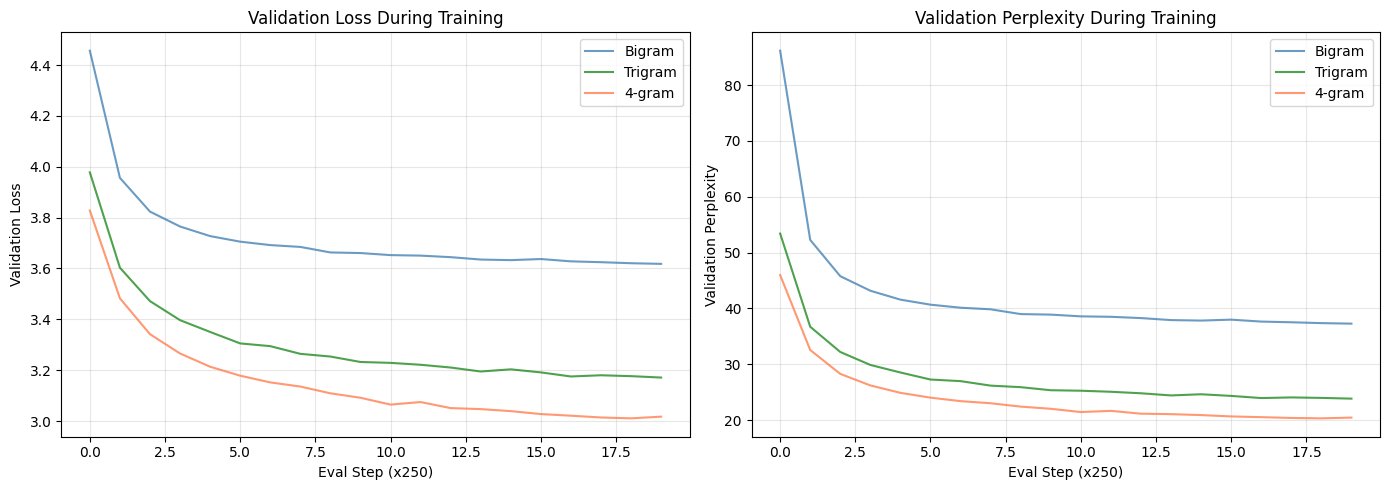

In [16]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

names = {1: 'Bigram', 2: 'Trigram', 3: '4-gram'}
colors = {1: 'steelblue', 2: 'forestgreen', 3: 'coral'}

# Validation loss
for n in [1, 2, 3]:
    axes[0].plot(results[n]['history']['val_loss'], 
                 label=names[n], color=colors[n], alpha=0.8)
axes[0].set_xlabel(f'Eval Step (x{EVAL_EVERY})')
axes[0].set_ylabel('Validation Loss')
axes[0].set_title('Validation Loss During Training')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Perplexity
for n in [1, 2, 3]:
    axes[1].plot(results[n]['history']['val_perplexity'], 
                 label=names[n], color=colors[n], alpha=0.8)
axes[1].set_xlabel(f'Eval Step (x{EVAL_EVERY})')
axes[1].set_ylabel('Validation Perplexity')
axes[1].set_title('Validation Perplexity During Training')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('03b_ngram_comparison.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

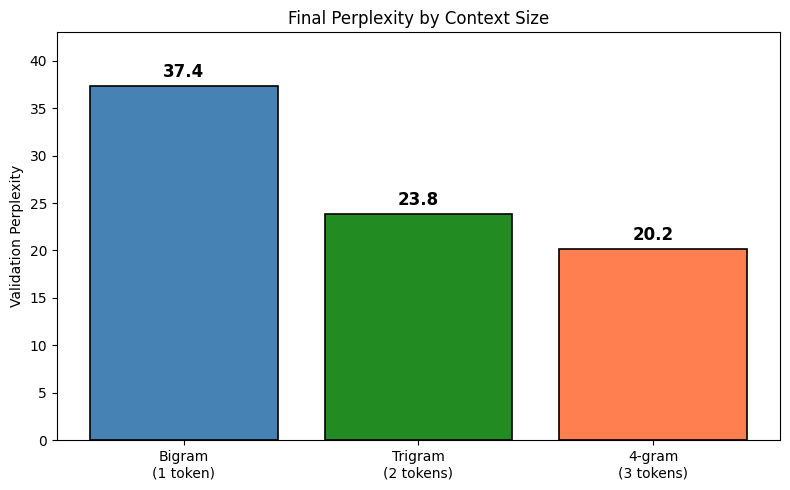

In [17]:
# Bar chart of final perplexities
fig, ax = plt.subplots(figsize=(8, 5))

models = ['Bigram\n(1 token)', 'Trigram\n(2 tokens)', '4-gram\n(3 tokens)']
perplexities = [results[n]['final_perplexity'] for n in [1, 2, 3]]
colors_list = [colors[n] for n in [1, 2, 3]]

bars = ax.bar(models, perplexities, color=colors_list, edgecolor='black', linewidth=1.2)

# Add value labels
for bar, ppl in zip(bars, perplexities):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{ppl:.1f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Validation Perplexity')
ax.set_title('Final Perplexity by Context Size')
ax.set_ylim(0, max(perplexities) * 1.15)

plt.tight_layout()
plt.savefig('03b_perplexity_bars.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

---

## 5. Analysis: What Does More Context Buy Us?

Let's look at specific predictions to understand the difference.

In [18]:
def compare_predictions(context_tokens, token_strs=None):
    """
    Compare predictions from all models given some context.
    
    Args:
        context_tokens: List of token IDs (at least 3 for 4-gram)
        token_strs: Optional list of token strings for display
    """
    if token_strs is None:
        token_strs = [tokenizer.decode_single(t) for t in context_tokens]
    
    print(f"Context: {' '.join(repr(s) for s in token_strs)}")
    print(f"Token IDs: {context_tokens}")
    print("-" * 50)
    
    for n in [1, 2, 3]:
        model = results[n]['model']
        model.eval()
        
        # Get the last n tokens
        ctx = context_tokens[-n:]
        x = torch.tensor([context_tokens], device=device)
        
        with torch.no_grad():
            logits = model(x)  # [1, num_preds, vocab]
            # Take the last prediction
            probs = F.softmax(logits[0, -1], dim=-1)
        
        top_probs, top_indices = probs.topk(5)
        
        name = {1: 'Bigram', 2: 'Trigram', 3: '4-gram'}[n]
        ctx_str = ' '.join(repr(tokenizer.decode_single(t)) for t in context_tokens[-n:])
        print(f"\n{name} (sees: {ctx_str}):")
        for prob, idx in zip(top_probs, top_indices):
            token_str = tokenizer.decode_single(idx.item())
            print(f"  {prob.item():.3f}: {repr(token_str)}")
    
    print()

In [19]:
# Test cases where more context should help
print("=" * 60)
print("PREDICTION COMPARISONS")
print("=" * 60)

# "girl named" vs "boy named" → should predict different names
girl_named = tokenizer.encode("the little girl named", add_eos=False)
compare_predictions(girl_named)

boy_named = tokenizer.encode("the little boy named", add_eos=False)
compare_predictions(boy_named)

# "once upon a" → should predict "time"
once_upon = tokenizer.encode("Once upon a", add_eos=False)
compare_predictions(once_upon)

PREDICTION COMPARISONS
Context: '<unk>' ' little' ' girl' ' named'
Token IDs: [1, 40, 63, 80]
--------------------------------------------------

Bigram (sees: ' named'):
  0.320: ' Lily'
  0.186: ' Tim'
  0.035: '<unk>'
  0.032: ' Lucy'
  0.031: ' Max'

Trigram (sees: ' girl' ' named'):
  0.570: ' Lily'
  0.047: ' Lucy'
  0.037: '<unk>'
  0.036: ' Jane'
  0.029: ' Sue'

4-gram (sees: ' little' ' girl' ' named'):
  0.594: ' Lily'
  0.047: ' Lucy'
  0.042: '<unk>'
  0.030: ' Sarah'
  0.028: ' Jane'

Context: '<unk>' ' little' ' boy' ' named'
Token IDs: [1, 40, 94, 80]
--------------------------------------------------

Bigram (sees: ' named'):
  0.320: ' Lily'
  0.186: ' Tim'
  0.035: '<unk>'
  0.032: ' Lucy'
  0.031: ' Max'

Trigram (sees: ' boy' ' named'):
  0.595: ' Tim'
  0.057: ' Tom'
  0.047: ' Jack'
  0.036: ' Max'
  0.024: ' Sam'

4-gram (sees: ' little' ' boy' ' named'):
  0.692: ' Tim'
  0.037: ' Tom'
  0.029: ' Lily'
  0.026: ' Jack'
  0.026: ' Joe'

Context: 'Once' ' upon' '

---

## 6. Summary and Implications

### What We Learned

In [20]:
print("=" * 60)
print("SUMMARY")
print("=" * 60)

ppls = {n: results[n]['final_perplexity'] for n in [1, 2, 3]}

print(f"\nFinal perplexities:")
print(f"  Bigram:  {ppls[1]:.1f}")
print(f"  Trigram: {ppls[2]:.1f} ({(ppls[1] - ppls[2])/ppls[1]*100:+.1f}% vs bigram)")
print(f"  4-gram:  {ppls[3]:.1f} ({(ppls[1] - ppls[3])/ppls[1]*100:+.1f}% vs bigram)")

# Determine the winner
best_n = min(ppls, key=ppls.get)
best_name = {1: 'Bigram', 2: 'Trigram', 3: '4-gram'}[best_n]
print(f"\nBest model: {best_name}")

# Analysis
if ppls[2] < ppls[1] and ppls[3] < ppls[2]:
    print("\nPattern: More context = strictly better")
    print("Implication: We should use even MORE context... but fixed windows have limits.")
elif ppls[2] < ppls[1] and ppls[3] >= ppls[2]:
    print("\nPattern: Diminishing returns (trigram helps, 4-gram doesn't help more)")
    print("Implication: More context helps up to a point. Sparsity or parameter cost kicks in.")
elif ppls[2] >= ppls[1]:
    print("\nPattern: More context doesn't help (or hurts!)")
    print("Implication: Raw context isn't enough. Need SELECTIVE context (attention).")
else:
    print("\nPattern: Non-monotonic (unexpected!)")
    print("Worth investigating further.")

SUMMARY

Final perplexities:
  Bigram:  37.4
  Trigram: 23.8 (+36.3% vs bigram)
  4-gram:  20.2 (+46.0% vs bigram)

Best model: 4-gram

Pattern: More context = strictly better
Implication: We should use even MORE context... but fixed windows have limits.


### Why This Motivates Attention

N-gram models have fundamental limitations:

1. **Fixed window size.** You choose N at architecture time. Can't adapt to "this prediction needs 2 tokens of context" vs "this prediction needs 10."

2. **No selectivity.** Every token in the window contributes equally (or with fixed learned weights). Can't say "attend to the subject, ignore the prepositions."

3. **Parameter growth.** The unembedding layer grows as N × d_model × vocab. Expensive.

4. **Data sparsity.** The more context you require, the fewer training examples of each exact context you see.

**Attention solves all of these:**
- Variable context (all predecessors available)
- Selective weighting (attend to what matters)
- Parameter efficient (same attention weights for any position)
- No sparsity problem (learns general patterns, not specific n-grams)

### Next Up

**Notebook 04: Add attention.** The fish grows eyes.

In [21]:
print("=" * 60)
print("NOTEBOOK 03b COMPLETE")
print("=" * 60)
print(f"\nWe tested whether more context (via n-grams) helps.")
print(f"")
print(f"The answer: {best_name} wins with perplexity {ppls[best_n]:.1f}")
print(f"")
print(f"But n-grams are a dead end for scaling.")
print(f"Time for attention.")

NOTEBOOK 03b COMPLETE

We tested whether more context (via n-grams) helps.

The answer: 4-gram wins with perplexity 20.2

But n-grams are a dead end for scaling.
Time for attention.
